In [2]:
import pandas as pd

import pandas as pd

# Load your datasets
admissions = pd.read_csv('HDHI Admission data.csv')
mortality = pd.read_csv('HDHI Mortality data.csv')
pollution = pd.read_csv('HDHI Pollution data.csv')

# Preview
print(admissions.head())
print(mortality.head())
print(pollution.head())

   SNO MRD No.     D.O.A      D.O.D  AGE GENDER RURAL  \
0    1  234735  4/1/2017   4/3/2017   81      M     R   
1    2  234696  4/1/2017   4/5/2017   65      M     R   
2    3  234882  4/1/2017   4/3/2017   53      M     U   
3    4  234635  4/1/2017   4/8/2017   67      F     U   
4    5  234486  4/1/2017  4/23/2017   60      F     U   

  TYPE OF ADMISSION-EMERGENCY/OPD month year  DURATION OF STAY  ...  \
0                               E     Apr-17                 3  ...   
1                               E     Apr-17                 5  ...   
2                               E     Apr-17                 3  ...   
3                               E     Apr-17                 8  ...   
4                               E     Apr-17                23  ...   

   CONGENITAL UTI  NEURO CARDIOGENIC SYNCOPE  ORTHOSTATIC  \
0           0   0                          0            0   
1           0   0                          0            0   
2           0   0                          0   

Lets clean, format, rename and merge on dates

In [5]:
#admissions
admissions['D.O.A'] = pd.to_datetime(admissions['D.O.A'], errors='coerce')
daily_admissions = admissions.groupby('D.O.A').size().reset_index(name='admission_count')
#mortality
mortality['DATE OF BROUGHT DEAD'] = pd.to_datetime(mortality['DATE OF BROUGHT DEAD'], errors='coerce')
daily_deaths = mortality.groupby('DATE OF BROUGHT DEAD').size().reset_index(name='death_count')
#pollution
pollution['DATE'] = pd.to_datetime(pollution['DATE'], errors='coerce')
pollution = pollution.rename(columns={'DATE': 'date'})

In [7]:
daily_admissions = daily_admissions.rename(columns={'D.O.A': 'date'})
daily_deaths = daily_deaths.rename(columns={'DATE OF BROUGHT DEAD': 'date'})

df = daily_admissions.merge(daily_deaths, on='date', how='outer')
df = df.merge(pollution, on='date', how='outer')

df[['admission_count', 'death_count']] = df[['admission_count', 'death_count']].fillna(0)

# Sort and preview
df = df.sort_values('date')
df.set_index('date', inplace=True)
df.head()

,admission_count,death_count,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-04,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.isna().sum()

admission_count         0
death_count             0
AQI                    38
PM2.5 AVG              38
PM2.5 MIN              38
PM2.5 MAX              38
PM10 AVG               38
PM10 MIN               38
PM10 MAX               38
NO2 AVG                38
NO2 MIN                38
NO2 MAX                38
NH3 AVG                38
NH3 MIN                38
NH3 MAX                38
SO2 AVG                38
SO2 MIN                38
SO2 MAX                38
CO AVG                 38
CO MIN                 38
CO MAX                 38
OZONE AVG              38
OZONE MIN              38
OZONE MAX              38
PROMINENT POLLUTENT    38
MAX TEMP               38
MIN TEMP               38
HUMIDITY               42
dtype: int64

In [11]:
df.fillna(method='ffill', inplace=True)

/var/folders/ty/10yr99n50cb3_p2pz_75mvxc0000gn/T/ipykernel_12878/3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


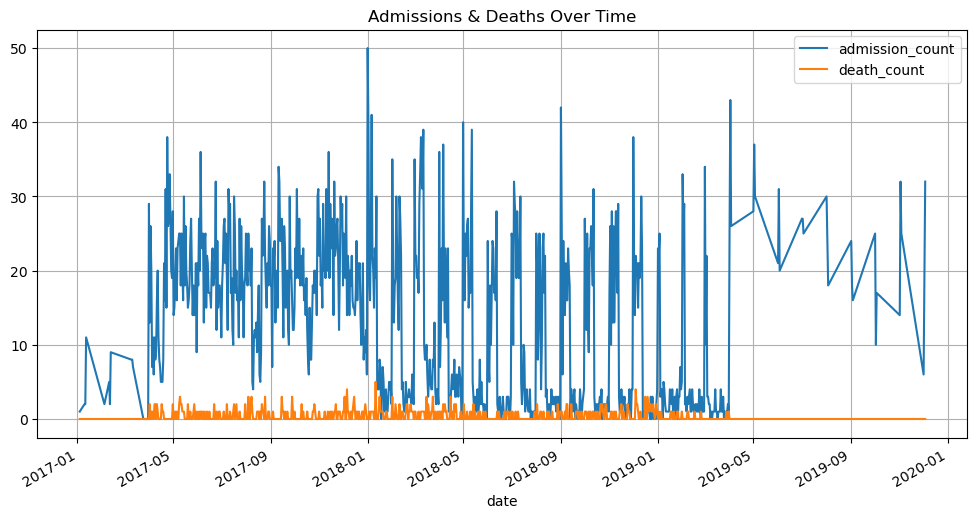

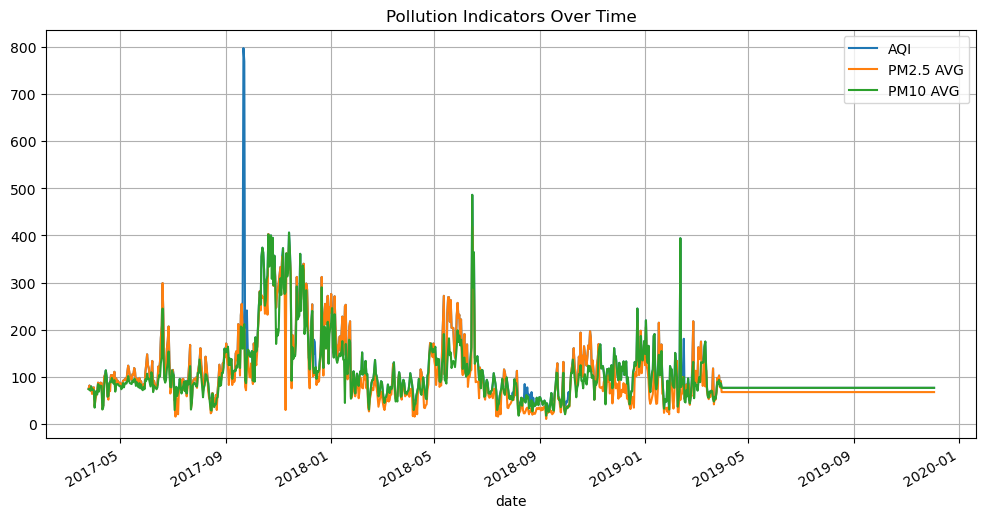

In [13]:
import matplotlib.pyplot as plt

df[['admission_count', 'death_count']].plot(figsize=(12,6))
plt.title("Admissions & Deaths Over Time")
plt.grid(True)
plt.show()

df[['AQI', 'PM2.5 AVG', 'PM10 AVG']].plot(figsize=(12,6))
plt.title("Pollution Indicators Over Time")
plt.grid(True)
plt.show()

In [15]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Ensure date is the index
df = df.sort_index()

# We'll use weekly data to smooth out noise (optional)
df_weekly = df[['admission_count', 'PM2.5 AVG']].resample('W').sum()

# Fill or interpolate missing values
df_weekly = df_weekly.interpolate(method='time')

# Target variable
y = df_weekly['admission_count']

# Exogenous variable (e.g., pollution)
exog = df_weekly[['PM2.5 AVG']]

model = SARIMAX(
    y,
    exog=exog,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                    admission_count   No. Observations:                  153
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -230.983
Date:                            Thu, 03 Apr 2025   AIC                            473.967
Time:                                    15:26:18   BIC                            484.939
Sample:                                01-08-2017   HQIC                           478.077
                                     - 12-08-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PM2.5 AVG      0.0192      0.015      1.250      0.211      -0.011       0.049
ar.L1         -0.2145      0.207   

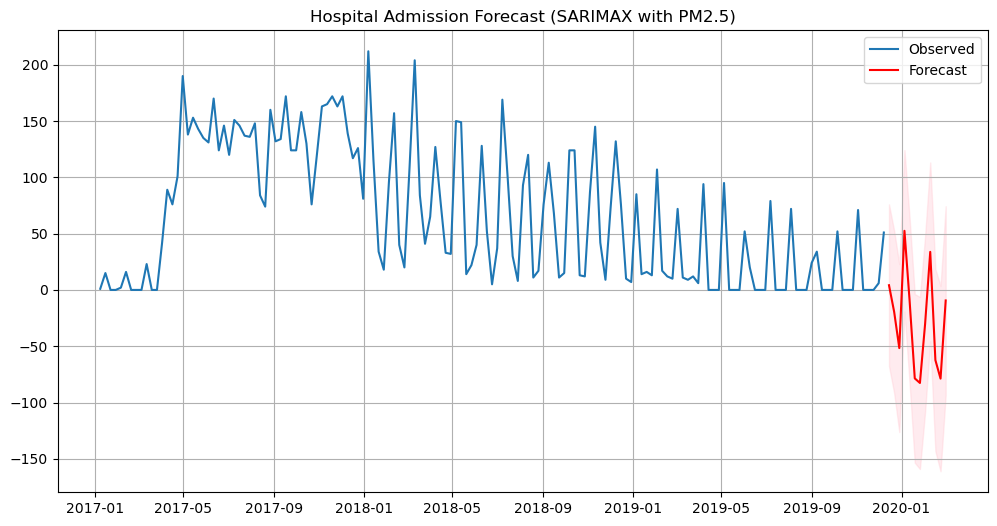

In [16]:
# Forecast horizon
forecast_steps = 12

# Create exogenous forecast input (use last known values for now)
future_exog = exog[-forecast_steps:]

# Forecast
pred = results.get_forecast(steps=forecast_steps, exog=future_exog)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(y, label='Observed')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Forecast', color='red')
plt.fill_between(
    pred.conf_int().index,
    pred.conf_int().iloc[:, 0],
    pred.conf_int().iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title("Hospital Admission Forecast (SARIMAX with PM2.5)")
plt.legend()
plt.grid(True)
plt.show()

Great, lets compare with baseline SARIMAX and then compare with pollution and mortality as drivers.

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Weekly resampling + interpolation
df_weekly = df[['admission_count', 'PM2.5 AVG', 'death_count']].resample('W').sum().interpolate(method='time')

y = df_weekly['admission_count']
exog_pm25 = df_weekly[['PM2.5 AVG']]
exog_pm25_death = df_weekly[['PM2.5 AVG', 'death_count']]

In [36]:
#baseline model
sarima = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,52)).fit(disp=False)

#model with pm25
sarimax_pm25 = SARIMAX(y, exog=exog_pm25, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)).fit(disp=False)

#model with pm25 and death as variables
sarimax_pm25_death = SARIMAX(y, exog=exog_pm25_death, order=(1,1,1), seasonal_order=(1,1,1,52)).fit(disp=False)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anac

Forecast with all three models

In [27]:
steps = 12
future_exog_pm25 = exog_pm25[-steps:]
future_exog_pm25_death = exog_pm25_death[-steps:]

pred_sarima = sarima.get_forecast(steps=steps)
pred_pm25 = sarimax_pm25.get_forecast(steps=steps, exog=future_exog_pm25)
pred_pm25_death = sarimax_pm25_death.get_forecast(steps=steps, exog=future_exog_pm25_death)

Lets do a plot comparison

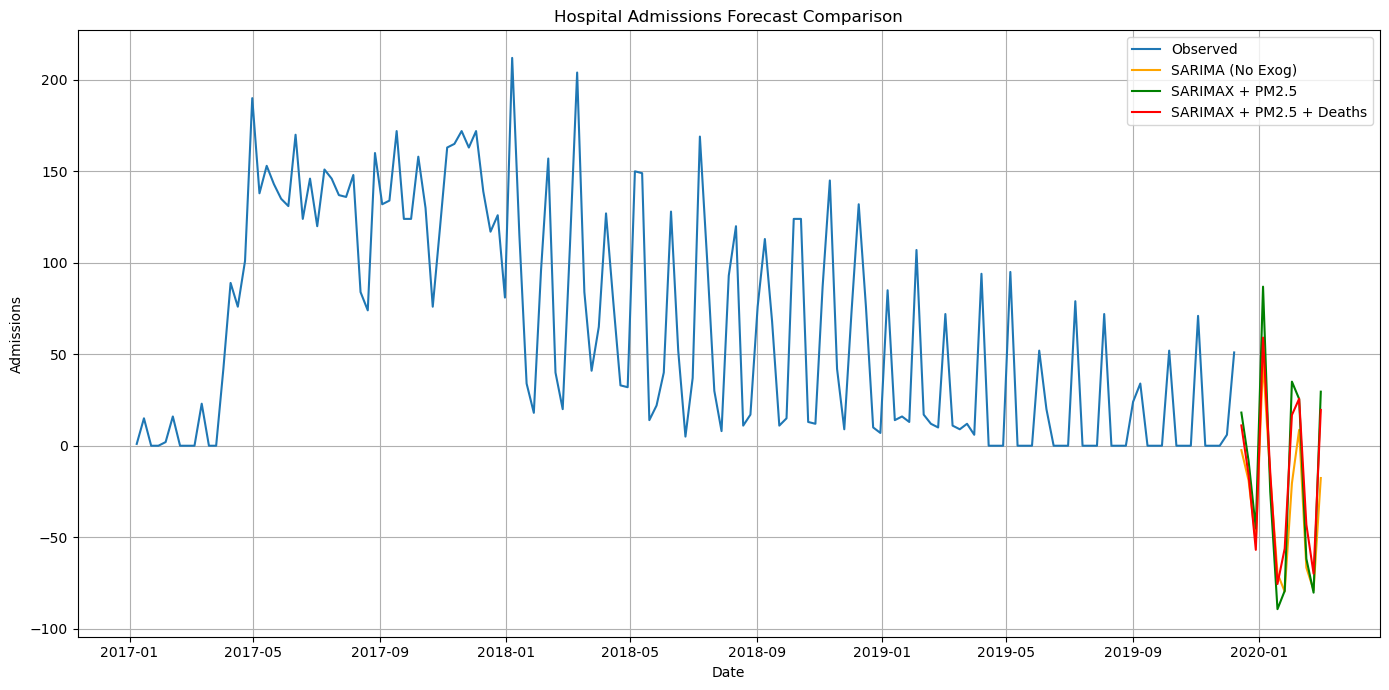

In [32]:
plt.figure(figsize=(14,7))
plt.plot(y, label='Observed')
plt.plot(pred_sarima.predicted_mean, label='SARIMA (No Exog)', color='orange')
plt.plot(pred_pm25.predicted_mean, label='SARIMAX + PM2.5', color='green')
plt.plot(pred_pm25_death.predicted_mean, label='SARIMAX + PM2.5 + Deaths', color='red')
plt.title("Hospital Admissions Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lets compare models using mean absolute error

In [41]:
from sklearn.metrics import mean_absolute_error

actual = y[-steps:]

mae_sarima = mean_absolute_error(actual, pred_sarima.predicted_mean)
mae_pm25 = mean_absolute_error(actual, pred_pm25.predicted_mean)
mae_pm25_death = mean_absolute_error(actual, pred_pm25_death.predicted_mean)

print(f"MAE - SARIMA: {mae_sarima:.2f}")
print(f"MAE - SARIMAX + PM2.5: {mae_pm25:.2f}")
print(f"MAE - SARIMAX + PM2.5 + Deaths: {mae_pm25_death:.2f}")

MAE - SARIMA: 54.94
MAE - SARIMAX + PM2.5: 58.81
MAE - SARIMAX + PM2.5 + Deaths: 50.46


Interestingly, adding PM2.5 alone worsens the model slightly suggesting that PM2.5 is not a strong short term predictor of admissions alone.

Combining pollution with mortality data reduced the MAE significantly. This suggests that mortality may act as a good proxy for severe health burden. 

Visually, the red line (PM2.5 + Death) tracks observed values (blue line) much more closely than the other 2.

Final insights:
Pollution may not be enough but combining with health impact indicators like mortality makes a stronger model

Lets compare Forecast admissions with prophet and see if it compares better than a SARIMA model

In [45]:
pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 28.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [49]:
from prophet import Prophet

# Create Prophet-friendly DataFrame
prophet_df = df_weekly[['admission_count']].reset_index().rename(columns={
    'date': 'ds',
    'admission_count': 'y'
})

m = Prophet(weekly_seasonality=True)
m.fit(prophet_df)# Create future dates
future = m.make_future_dataframe(periods=12, freq='W')

# Forecast
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)

15:54:53 - cmdstanpy - INFO - Chain [1] start processing
15:54:54 - cmdstanpy - INFO - Chain [1] done processing


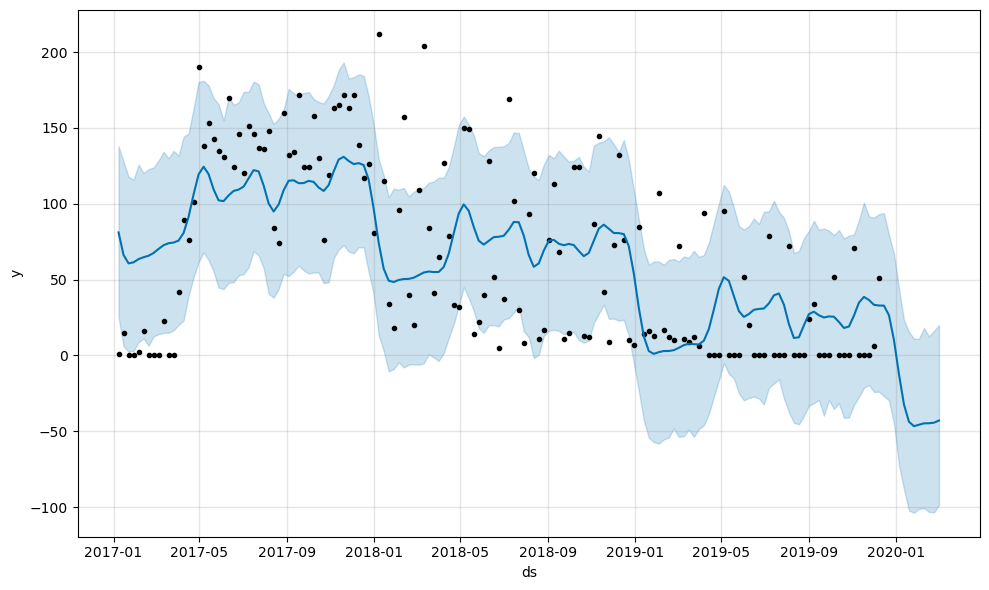

In [51]:
# Create future dates
future = m.make_future_dataframe(periods=12, freq='W')

# Forecast
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)

In [53]:
from sklearn.metrics import mean_absolute_error

# Align predictions with actual
predicted = forecast.set_index('ds')['yhat'][-12:]
actual = df_weekly['admission_count'][-12:]

mae_prophet = mean_absolute_error(actual, predicted)
print(f"MAE - Prophet: {mae_prophet:.2f}")

MAE - Prophet: 48.87


In [55]:
print(f"MAE - SARIMA: {mae_sarima:.2f}")
print(f"MAE - SARIMAX + PM2.5: {mae_pm25:.2f}")
print(f"MAE - SARIMAX + PM2.5 + Deaths: {mae_pm25_death:.2f}")
print(f"MAE - Prophet: {mae_prophet:.2f}")

MAE - SARIMA: 54.94
MAE - SARIMAX + PM2.5: 58.81
MAE - SARIMAX + PM2.5 + Deaths: 50.46
MAE - Prophet: 48.87


From the results we can see Prophet performs very well, even without exogenous inputs. Prophet beats the SARIMA baseline and SARIMAX PM2.5 model. It effectively captures seasonality. The hybrid model was strong but not the best.